# Concrete Solutions to Real Problems using NLP
## A Code-lab session by Charmi Chokshi [(@CharmiChokshi)](https://twitter.com/CharmiChokshi) at #DevFestAhm18


- What is NLP?
- Human vs Computer understanding of language
- The real reason why NLP is hard
-  What do you think the following piece of text means?
```
    “Steph Curry was on fire last night. He totally destroyed the other team”
```
- How does human interprete this?
- How does computer may interprete this?

![alt text](https://cdn-images-1.medium.com/max/800/1*gmL2WA-hoXe8HokFZ9wXIA.gif)




---


##Make Google do it!!



![alt text](http://1.bp.blogspot.com/-LKKJSDcnA5Y/UFokf-p9vhI/AAAAAAAAVaQ/QwSWElPclHM/s1600/imgres-12.jpeg)
![alt text](https://pbs.twimg.com/media/C63ehfyWkAEdVhR.jpg:large)


##Applications of NLP
![alt text](https://image.ibb.co/kkaABL/NLP-768x356.png)



---



# How to solve 90% of NLP problems
###Step 1: Gather your data
###Step 2: Clean your data
###Step 3: Find a good data representation (One-hot encoding (Bag of Words))
###Step 4: Classification
###Step 5: Inspection (Confusion Matrix, Explaining and interpreting our model)
###Step 6: Not satisfied? Repeat. :D






---
## Social Media Text Analysis for Disaster Management

### Our Dataset: 
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous). Thank you [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

### Why it matters
We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:
- It is actionable to anybody trying to get signal from noise (such as police departments in this case)
- It is tricky because relying on keywords is harder than in most cases like spam or emotion analysis


---



In [0]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

Using TensorFlow backend.


##All you need is Labels over Love! :D
![alt text](https://cdn-images-1.medium.com/max/800/1*CdnxyA_fMXxEcEQ1kUTFRg.png)

## Let's inspect the data


In [0]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')

questions = pd.read_csv(input_file)
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

# class_label: 0 : Not Relevant
# class_label: 1 : Relevant
# class_label: 2 : Can't decide

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [0]:
questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


###Let's use a few regular expressions to clean up our data, and save it back to disk for future use

![alt text](https://cdn-images-1.medium.com/max/1600/1*44nbQ40A1XYe97bixBgCOw.gif)




---



### Sanitizing input

Have a close look at the data...


It looks solid, but we don't really need urls, and we would like to have our words all lowercase (Hello and HELLO are pretty similar for our task)


Remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [0]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()

    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [0]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10871,10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,10872,police investigating after an e bike collided ...,Relevant,1
10873,10873,the latest more homes razed by northern calif...,Relevant,1
10874,10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,10875,cityofcalgary has activated its municipal eme...,Relevant,1


## Data Overview

### Let's look at our class balance.

In [0]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6187,6187,6187
1,4673,4673,4673
2,16,16,16


### Our data is clean, now it needs to be prepared
Now that our inputs are more reasonable, let's transform our inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Inspecting our data a little more to validate results
- Creating a train test split


In [0]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [0]:
# Inspecting our dataset a little more

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

154724 words total, with a vocabulary size of 18101
Max sentence length is 34


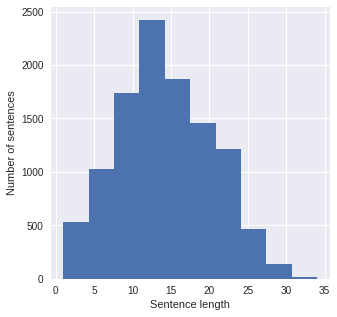

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()



---


## On to the Machine Learning
Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?



### BAG OF WORDS 
![alt text](https://conleyst.github.io/img/bears-beets-nlp/bow-example1.png)

Our goal is to first **create a useful embedding** for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.
###What is BoW?
The bag-of-words model is commonly used in methods of document classification where **the (frequency of) occurrence of each word is used as a feature for training a classifier**
![alt text](https://cdn-images-1.medium.com/max/800/1*oQ3suk0Ayc8z8i1QIl5Big.png)


The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top of it. 
###What is LR?
![alt text](https://www.saedsayad.com/images/LogReg_1.png)



In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()           # Convert a collection of text documents to a matrix of token counts
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings

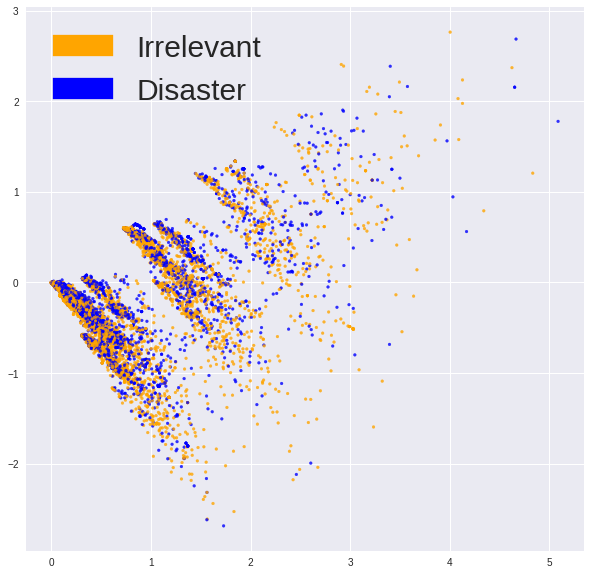

In [0]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

### Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [0]:
from sklearn.linear_model import LogisticRegression

# newton-cg solver
  # support only L2 regularization
  # It can handle both dense and sparse input
# multiclass data, here 3
# c: regularization constant
# n_jobs: -1 means using all processors  
# random_state is the seed used by the random number generator to use when shuffling the data
# “balanced” mode automatically adjust weights inversely proportional to class frequencies   

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### Evaluation
Let's start by looking at some metrics to see if our classifier performed well at all.
![alt text](https://cdn-images-1.medium.com/max/1600/1*CPnO_bcdbE8FXTejQiV2dg.png)

In our example, false positives are classifying an irrelevant tweet as a disaster, and false negatives are classifying a disaster as an irrelevant tweet.

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


### Inspection
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.



In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

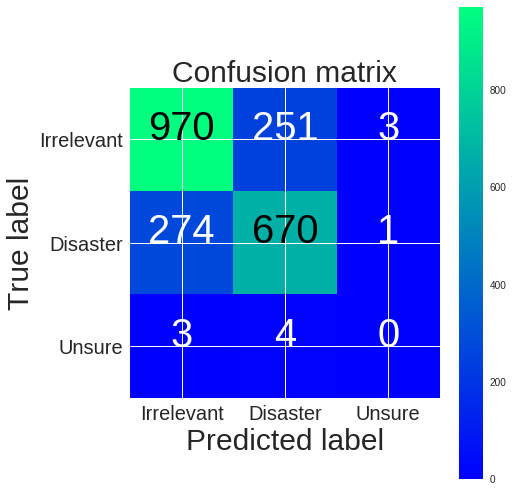

[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [0]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(7, 7))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

### Further inspection
Let's look at the features our classifier is using to make decisions.

In [0]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

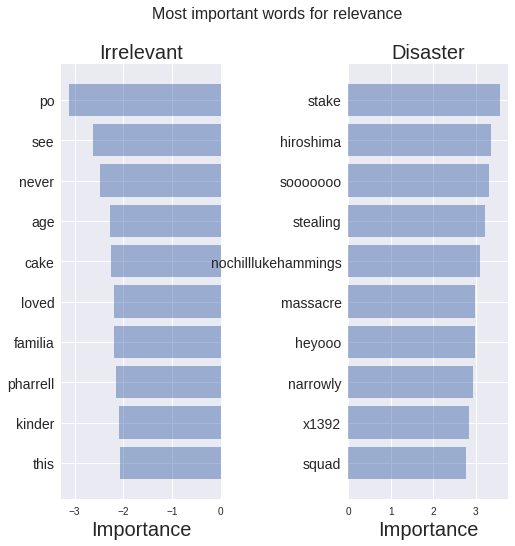

In [0]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(8, 8))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Our classifier correctly picks up on some patterns (hiroshima, massacre), but clearly seems to be overfitting on some irellevant terms (heyoo, x1392)


##What else we can explore?
- TFIDF on top of BoW (acc: 76.2%)
- word2vec/LDA (acc: 77.7%)
- CNN/DNN for Text Classification (acc: 79.5%)
- RNN/LSTM 
- Zero-shot learning

##Final Notes
Here is a quick recap of the approach we’ve successfully used:

- Start with a quick and simple model
- Explain its predictions
- Understand the kind of mistakes it is making
- Use that knowledge to inform your next step, whether that is working on your data, or a more complex model

##Reference
- [Concrete NLP Tutorial](https://github.com/hundredblocks/concrete_NLP_tutorial)
- [NLP: Step by step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)
- [Awesome-NLP](https://github.com/keon/awesome-nlp)

# Happy Learning! :)
Let's connect 
- [LinkedIn](https://www.linkedin.com/in/charmichokshi/)
- [Twitter](https://twitter.com/CharmiChokshi)
- [Github](https://github.com/charmichokshi/)